In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../..")

from gob.benchmarks import *
from gob.optimizers import *
import matplotlib
matplotlib.rcParams.update({"text.usetex": True})

In [2]:
class MinWrapper:
  def __init__(self, func):
    self.func = func
    self.visual_bounds = func.visual_bounds
    self.values = []
  
  def __call__(self, x):
    y = self.func(x)
    self.values.append(y)
    return y
  
  def get_min_per_iteration(self, n_particles):
    mins = []
    for i in range(len(self.values) // n_particles + 1):
      prev_min = mins[-1] if mins else float("inf")
      actual_min = np.min(self.values[i * n_particles : (i + 1) * n_particles])
      mins.append(min(prev_min, actual_min))
    return mins

class MinWrapperGrad:
  def __init__(self, func):
    self.func = func
    self.visual_bounds = func.visual_bounds
    self.values = []
    self.prev_sample = None
  
  def __call__(self, x):
    y = self.func(x)
    if self.prev_sample is None or not np.all(np.abs(x - self.prev_sample) <= 2e-9):
      self.values.append(y)
    self.prev_sample = x
    return y
  
  def get_min_per_iteration(self, n_particles):
    mins = []
    for i in range(len(self.values) // n_particles):
      prev_min = mins[-1] if mins else float("inf")
      actual_min = np.min(self.values[i * n_particles : (i + 1) * n_particles])
      mins.append(min(prev_min, actual_min))
    return mins

In [ ]:
def format_results(res):
  for i in range(len(res)):
    if len(res[i]) < iter:
      print(f"Run {i} of mins has length {len(res[i])} instead of {iter}")
      # Copy the last value to extend the length
      last_value = res[i][-1]
      res[i] = list(res[i]) + [last_value] * (iter - len(res[i]))

In [4]:
g = Ackley()
dim = 8
bounds = augment_dimensions(g.visual_bounds, dim)
n_particles = 150
iter = 800
verbose = False
n_runs = 5
wrapper = MinWrapper
alg = CBO
cn_alg = CN_CBO

In [5]:
mins = []
for i in range(n_runs):
  f = wrapper(g)

  opt = alg(bounds=bounds, n_particles=n_particles, iter=iter, verbose=verbose)
  res = opt.minimize(f)
  print(f"Results for {opt}: {res[1]}")
  mins.append(f.get_min_per_iteration(n_particles)[:iter])

format_results(mins)
mins = np.array(mins)

Results for CBO: 16.91003444488719
Results for CBO: 15.243623412182266
Results for CBO: 16.134079746526428
Results for CBO: 15.760965422212443
Results for CBO: 16.149136522489076


In [6]:
mins_m1 = []
for i in range(n_runs):
  f = wrapper(g)

  opt = cn_alg(bounds=bounds, n_particles=n_particles, iter=iter, verbose=verbose, moment="M1")
  res = opt.minimize(f)
  print(f"Results for {opt}: {res[1]}")
  mins_m1.append(f.get_min_per_iteration(n_particles)[:iter])

format_results(mins_m1)
mins_m1 = np.array(mins_m1)

Results for CN-CBO: 4.511528708068408
Results for CN-CBO: 0.4329471210016007
Results for CN-CBO: 6.775283678721433
Results for CN-CBO: 1.1521931009318824
Results for CN-CBO: 2.6654594321898313


In [7]:
mins_m2 = []
for i in range(n_runs):
  f = wrapper(g)

  opt = cn_alg(bounds=bounds, n_particles=n_particles, iter=iter, verbose=verbose, moment="M2")
  res = opt.minimize(f)
  print(f"Results for {opt}: {res[1]}")
  mins_m2.append(f.get_min_per_iteration(n_particles)[:iter])

format_results(mins_m2)
mins_m2 = np.array(mins_m2)

Results for CN-CBO: 0.5161610755094199
Results for CN-CBO: 0.384201672998874
Results for CN-CBO: 0.7624873238938048
Results for CN-CBO: 1.0139470610211068
Results for CN-CBO: 0.259246266261727


In [8]:
mins_var = []
for i in range(n_runs):
  f = wrapper(g)

  opt = cn_alg(bounds=bounds, n_particles=n_particles, iter=iter, verbose=verbose, moment="VAR")
  res = opt.minimize(f)
  print(f"Results for {opt}: {res[1]}")
  mins_var.append(f.get_min_per_iteration(n_particles)[:iter])

format_results(mins_var)
mins_var = np.array(mins_var)

Results for CN-CBO: 0.14009137361706836
Results for CN-CBO: 0.15351606901014891
Results for CN-CBO: 0.4779378522047968
Results for CN-CBO: 0.39979877634647965
Results for CN-CBO: 0.22420836561285684


In [9]:
mins_mvar = []
for i in range(n_runs):
  f = wrapper(g)

  opt = cn_alg(bounds=bounds, n_particles=n_particles, iter=iter, verbose=verbose, moment="MVAR")
  res = opt.minimize(f)
  print(f"Results for {opt}: {res[1]}")
  mins_mvar.append(f.get_min_per_iteration(n_particles)[:iter])

format_results(mins_mvar)
mins_mvar = np.array(mins_mvar)

Results for CN-CBO: 1.2095380367081074
Results for CN-CBO: 0.7574754664886041
Results for CN-CBO: 1.1741297524765462
Results for CN-CBO: 2.849628075820498
Results for CN-CBO: 2.036749209747413


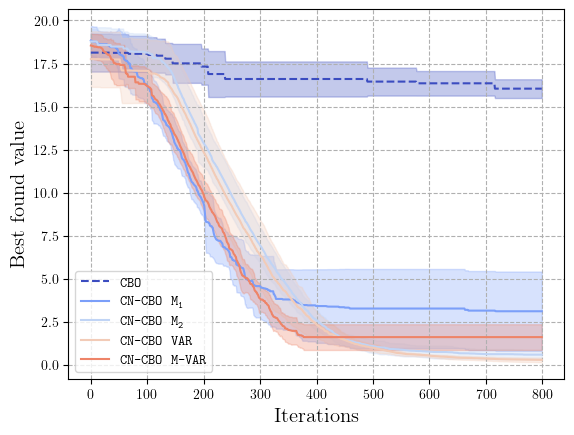

In [10]:
alg_name = str(alg([]))
cn_alg_name = str(cn_alg([]))

latex_label = lambda s: r"\texttt{" + s.replace("_", r"\_") + "}"

cmap = matplotlib.colormaps["coolwarm"]

c0 = cmap(0)
c1 = cmap(0.2)
c2 = cmap(0.4)
c3 = cmap(0.6)
c4 = cmap(0.8)

mean = mins.mean(axis=0)
std = mins.std(axis=0)
plt.plot(mean, label=latex_label(alg_name), linestyle="--", color=c0)
plt.fill_between(range(iter), mean - std, mean + std, alpha=0.3, color=c0)

mean = mins_m1.mean(axis=0)
std = mins_m1.std(axis=0)
plt.plot(mean, label=latex_label(f"{cn_alg_name} M" + r"\textsubscript{1}"), linestyle="-", c=c1)
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.3, color=c1)

mean = mins_m2.mean(axis=0)
std = mins_m2.std(axis=0)
plt.plot(mean, label=latex_label(f"{cn_alg_name} M" + r"\textsubscript{2}"), linestyle="-", c=c2)
plt.fill_between(range(iter), mean - std, mean + std, alpha=0.3, color=c2)

mean = mins_var.mean(axis=0)
std = mins_var.std(axis=0)
plt.plot(mean, label=latex_label(f"{cn_alg_name} VAR"), linestyle="-", c=c3)
plt.fill_between(range(iter), mean - std, mean + std, alpha=0.3, color=c3)

mean = mins_mvar.mean(axis=0)
std = mins_mvar.std(axis=0)
plt.plot(mean, label=latex_label(f"{cn_alg_name} M-VAR"), linestyle="-", c=c4)
plt.fill_between(range(iter), mean - std, mean + std, alpha=0.3, color=c4)

plt.xlabel(r"$\textrm{Iterations}$", fontsize=15)
plt.ylabel(r"$\textrm{Best found value}$", fontsize=15)
plt.grid(linestyle="--")
plt.legend()
plt.savefig(f"impact_noise_{alg_name.lower()}.pdf", bbox_inches="tight")